### Обучение матриц проекции

Реализуем процесс обучения матриц проекции, который был предложен на SemEval CRIM. Для этого сначала требуется загрузить какие-нибудь эмбеддинги для слов и подобрать то, каких именно кандидатов требуется ранжировать при выдаче гиперонимов.

Начнём с простой стратегии. Возьмём обученную модель FastText и загрузим эмбеддинги из неё. После этого будем для многословных термов усреднять эмбеддинги.

In [259]:
import sys
import json
from os.path import join
import os
sys.path.append("../")
import fasttext as ft
from thesaurus_parsing.thesaurus_parser import ThesaurusParser
from collections import Counter
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [143]:
deeppavlov_embeddings = ft.load_model('../data/models/fasttext_deeppavlov.bin')

In [144]:
len(deeppavlov_embeddings.get_words())

1572343

Мы видим, что здесь есть векторы для полутора миллионов слов. Конечно же, использовать их все, как кандидаты в гиперонимы, было бы хорошо. Но тем не менее, поскольку метод в основном похож на kNN, это будет очень долго.

Вследствие этого, необходимо, кроме сущностей тезауруса, оставить лишь некоторый топ в качестве кандидатов в гиперонимы. Этот топ можно подобрать по tf-idf. Но для начала надо построить векторы для сущностей из тезауруса.

In [145]:
thesaurus = ThesaurusParser("../data/RuThes", need_closure=False)

In [146]:
vocab_embeddings = dict()

In [147]:
for _, entry_dict in thesaurus.text_entries.items():
    lemma = entry_dict['lemma']
    vocab_embeddings[lemma] = deeppavlov_embeddings.get_sentence_vector(lemma)

In [148]:
len(vocab_embeddings)

110176

Давайте пройдём по всем текстам, которые загрузились на данный момент, для слов, которые есть в словаре, посчитаем частоту слов

In [149]:
DIR_PATH = "/home/loginov-ra/MIPT/HypernymyDetection/data/Lenta/texts_tagged_processed_tree"
file_list = os.listdir(DIR_PATH)
file_list = [join(DIR_PATH, filename) for filename in file_list]

In [150]:
word_ctr = Counter()
no_deeppavlov = 0

for filename in tqdm(file_list):
    with open(filename, encoding='utf-8') as sentences_file:
        sentences = json.load(sentences_file)
        for sent in sentences:
            if 'deeppavlov' not in sent:
                no_deeppavlov += 1
                continue
            
            multitokens, _ = sent['multi']
            for t in multitokens:
                word_ctr[t] += 1

In [151]:
print(no_deeppavlov)

503


In [152]:
word_ctr.most_common(n=28)

[(',', 330573),
 ('.', 281677),
 ('в', 195348),
 ('"', 188495),
 ('на', 79988),
 ('и', 78751),
 ('-', 70551),
 ('с', 49500),
 ('что', 46036),
 ('быть', 45393),
 ('по', 44794),
 ('год', 36389),
 ('о', 33339),
 ('не', 30394),
 (')', 30202),
 ('(', 29806),
 ('который', 26841),
 ('он', 25806),
 (':', 24555),
 ('это', 23760),
 ('из', 23661),
 ('тот', 20564),
 ('за', 18168),
 ('как', 18110),
 ('один', 17231),
 ('--', 16571),
 ('к', 14900),
 ('сообщать', 14694)]

Видим, что для первых $27$ слов нет необходимости искать гиперонимы, для остальных уже может быть. Поэтому возьмёи пока первые $100000$ слов для работы с ними, посчитаем их эмбеддинги и добавим в словарь.

In [153]:
additional_words = word_ctr.most_common(n=100000)[27:]

In [154]:
for word, _ in additional_words:
    vocab_embeddings[word] = deeppavlov_embeddings.get_word_vector(word)

Удалим модель за ненадобностью

In [155]:
del deeppavlov_embeddings

In [156]:
len(vocab_embeddings)

172996

Видим, что было пересечение, и добавилась где-то 61000 слов
_________________

**Определение модели**

Определим модель, в которой будет 5 матриц проекции и логистическая регрессия на косинусных расстояниях до проекций.

In [157]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

In [158]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [159]:
device

'cpu'

In [160]:
class CRIMModel(nn.Module):
    def __init__(self, n_matrices=5, embedding_dim=300, init_sigma=0.01):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_matrices = n_matrices
        self.init_sigma = init_sigma
        
        matrix_shape = (n_matrices, 1, embedding_dim, embedding_dim)
        self.matrices = torch.FloatTensor(size=matrix_shape, device=device)
        self.prob_layer = nn.Linear(in_features=n_matrices, out_features=1)
        
        for i in range(n_matrices):
            eye_tensor = torch.FloatTensor(size=(embedding_dim, embedding_dim), device=device)
            noise_tensor = torch.FloatTensor(size=(embedding_dim, embedding_dim), device=device)
            torch.nn.init.eye_(eye_tensor)
            torch.nn.init.normal_(noise_tensor, std=init_sigma)
            self.matrices[i][0] = eye_tensor + noise_tensor
            
        torch.nn.init.normal_(self.prob_layer.weight, std=0.1)
        self.matrices = self.matrices.requires_grad_()
        
    def forward(self, input_dict):
        candidate = input_dict['candidate']
        candidate_batch = candidate.shape[0]
        candidate = candidate.view((candidate_batch, 1, self.embedding_dim))
        batch = input_dict['batch'].unsqueeze(-1)
        batch_size = batch.shape[0]
        projections = torch.matmul(self.matrices, batch).permute(1, 0, 2, 3).squeeze(-1)
        similarities = F.cosine_similarity(projections, candidate, dim=-1)
        logits = self.prob_layer(similarities)
        probas = torch.sigmoid(logits)
        return probas

In [161]:
model = CRIMModel()

In [162]:
args = {
    'batch': torch.randn(64, 300),
    'candidate': torch.randn(1, 300)
}

In [163]:
probas = model(args)

In [164]:
optimizer = Adam(model.parameters(), lr=1)

In [135]:
while True:
    probas = model(args)
    loss = probas.sum()
    print('Loss:', loss.detach().numpy())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

Loss: 25.325897
Loss: 12.469554
Loss: 5.4112926
Loss: 2.321445
Loss: 1.0680344
Loss: 0.53654784
Loss: 0.29242
Loss: 0.17099519
Loss: 0.10618677
Loss: 0.06942666
Loss: 0.047455765
Loss: 0.03371688
Loss: 0.024781276
Loss: 0.01876633
Loss: 0.014593014
Loss: 0.011618889
Loss: 0.009448345
Loss: 0.007830288
Loss: 0.006600968
Loss: 0.0056509404
Loss: 0.0049054106
Loss: 0.004312218
Loss: 0.0038343102
Loss: 0.0034449147
Loss: 0.0031243796
Loss: 0.0028580735
Loss: 0.0026349549
Loss: 0.002446588
Loss: 0.002286452
Loss: 0.0021494555
Loss: 0.0020315787
Loss: 0.0019296202
Loss: 0.0018410089
Loss: 0.0017636613
Loss: 0.0016958753
Loss: 0.0016362526


KeyboardInterrupt: 

Во всяком случае, на текущий момент возможно переобучить модель под нужные значения
_________________

**Цикл обучения модели**

Для того, чтобы обучить модель, надо сделать следующие шаги:

* Добавить пары корректных гипонимов-гиперонимов
* Для каждого положительного добавить несколько отрицательных (пока просто случайные слова)
* Добавить вектор правильных ответов

Сделаем из этого `torch.Dataset`

In [222]:
class HypernymQueriesDataset(Dataset):
    def load_train_items(self, thesaurus, vocab):
        self.train_items = []
        for hyponym, hypernyms in tqdm(thesaurus.hypernyms_dict.items()):
            for hypernym in hypernyms:
                self.train_items.append([hyponym, hypernym, True])
            
            negative_examples = np.random.choice(list(vocab.keys()), size=self.n_negative * len(hypernyms))
            for negative in negative_examples:
                self.train_items.append([hyponym, negative, False])
                
            if self.max_pairs is not None and len(self.train_items) > self.max_pairs:
                break
    
    def __init__(self, thesaurus, vocab, n_negative=3, max_pairs=None):
        self.n_negative = n_negative
        self.thesaurus = thesaurus
        self.vocab = vocab
        self.max_pairs = max_pairs
        
        self.load_train_items(thesaurus, vocab)
        
    def __len__(self):
        return len(self.train_items)
    
    def __getitem__(self, idx):
        hyponym, hypernym, label = self.train_items[idx]
        return (self.vocab[hyponym], self.vocab[hypernym], label)

In [285]:
dataset = HypernymQueriesDataset(thesaurus, vocab_embeddings, max_pairs=1000000)

In [301]:
model = CRIMModel(n_matrices=24)
optimizer = Adam(model.parameters(), lr=3e-4)
n_epochs = 4
batch_size = 16
plot_frequency = 40

In [302]:
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

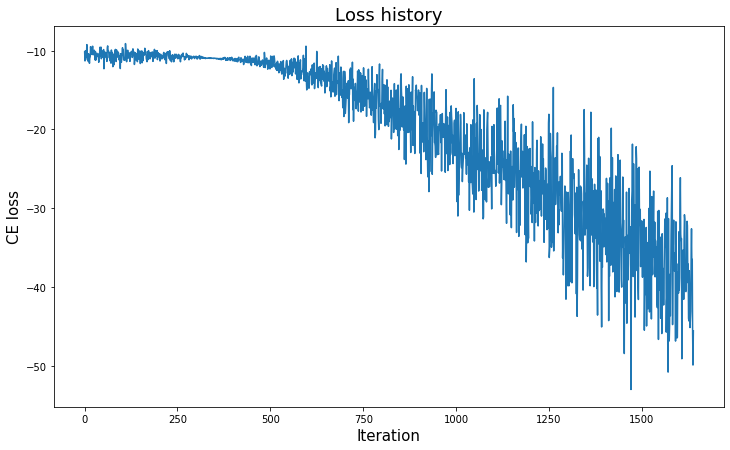

In [ ]:
loss_history = []

for epoch in range(n_epochs):
    print('Epoch {}. Started training.'.format(epoch + 1))

    for it, batch in tqdm(enumerate(data_loader)):
        hyponyms, candidates, labels = batch

        model_batch = {
            'batch': hyponyms,
            'candidate': candidates
        }

        labels = labels.float()
        probas = model(model_batch).squeeze()
        probas = torch.clamp(probas, 1e-5, 1. - 1e-5)
        loss = torch.sum(labels * torch.log(probas) + (1. - labels) * torch.log(1. - probas))
        loss_history.append(loss.detach().numpy())
        
        if len(loss_history) % plot_frequency == 0:
            print(loss)
            clear_output(wait=True)
            plt.figure(figsize=(12, 7))
            plt.title('Loss history', fontsize=18)
            plt.xlabel('Iteration', fontsize=15)
            plt.ylabel('CE loss', fontsize=15)
            plt.plot(np.array(loss_history))
            plt.show()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()